# Metagenomic-based Diagnostic for Sepsis (External Validation)

In [2]:
# Import Statements
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

cwd = Path.cwd()
datasets = cwd / 'datasets'
results = cwd / 'results'

In [3]:
list(datasets.glob('*'))

[PosixPath('/home/csctan/git_repos/Polymicrobial-Signature-of-Sepsis/datasets/kapusta_genus_raw.csv'),
 PosixPath('/home/csctan/git_repos/Polymicrobial-Signature-of-Sepsis/datasets/karius_genus_raw.csv'),
 PosixPath('/home/csctan/git_repos/Polymicrobial-Signature-of-Sepsis/datasets/pathogen_list.csv'),
 PosixPath('/home/csctan/git_repos/Polymicrobial-Signature-of-Sepsis/datasets/contaminant_list.txt')]

## Data Preprocessing
Since we are using stratified kfold, a validation split is not necesssary.

### Load data

In [4]:
raw_df = pd.read_csv(datasets / 'kapusta_genus_raw.csv')

# Remove NTCs
raw_df = raw_df.loc[raw_df.y != 'ntc', :]
display(raw_df)

X = raw_df.iloc[:, 1:].copy()
y = raw_df.iloc[:, 0].copy()

,y,Bifidobacterium,Aeriscardovia,Alloscardovia,Arthrobacter,Kocuria,Glutamicibacter,Citricoccus,Enteractinococcus,Micrococcus,...,Gallicola,Dethiosulfatibacter,Bilophila,Guyparkeria,Sinobaca,Cryptanaerobacter,Marinitoga,Candidatus Endolissoclinum,Luteimicrobium,Paeniclostridium
0,healthy,52711.0,1.0,1.0,199.0,3.0,2.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,healthy,29182.0,0.0,0.0,35.0,6.0,3.0,0.0,1.0,81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,septic,33.0,0.0,0.0,215.0,82.0,59.0,1.0,3.0,144.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,septic,3.0,0.0,0.0,35.0,23.0,13.0,0.0,0.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,septic,2.0,0.0,0.0,299.0,78.0,87.0,0.0,4.0,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,septic,35.0,1.0,0.0,1285.0,295.0,275.0,7.0,11.0,382.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
77,septic,128.0,0.0,0.0,1745.0,132.0,120.0,3.0,7.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,septic,14.0,0.0,0.0,87.0,30.0,18.0,0.0,3.0,38.0,...,60.0,3.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,septic,811.0,0.0,0.0,642.0,159.0,122.0,5.0,7.0,188.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0


In [5]:
# Binary encode y
y.loc[y == 'septic'] = 1
y.loc[y == 'healthy'] = 0
y = y.astype('int')

# Relative abundance
X_RA = X.apply(func=lambda x: x / x.sum(), axis=1)

In [8]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'Septic': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'Healthy': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,Septic,Healthy
Train fold,50,21
Test fold,5,2


## Nested CV for hyperparameter optimisation

In [9]:
# Metrics
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.model_selection import cross_validate

In [10]:
def optimise(X, y, param_dict=False):
    np.random.seed(66)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(50, 500, 1)
    max_depth = range(1, 10)
    gamma = np.linspace(0, 5, 20)
    subsample = np.linspace(0.1, 1, 20)
    colsample_bytree = np.linspace(0.1, 1, 20)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True)
    
    if not param_dict:
        # Inner CV
        model = RandomizedSearchCV(model, 
                                   param_grid, 
                                   scoring="roc_auc",
                                   n_iter=1000,
                                   n_jobs=10, 
                                   cv=inner_cv, 
                                   verbose=1)

        model.fit(X, y)
        best_params = model.best_params_
        print(best_params)
                
    else:
        model = XGBClassifier(**param_dict)
        model.fit(X, y)
        best_params = param_dict

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc'}
    
    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_AUROC']]
    
    return model, outer_results, best_params

### Optimise Model using Neat Data

In [ ]:
raw_model, raw_results, raw_params = optimise(X, y)
# raw_params = {'subsample': 0.5263157894736842, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 96, 'max_depth': 2, 'gamma': 1.8421052631578947, 'colsample_bytree': 0.19473684210526315}
# raw_model, raw_results, _ = optimise(X, y, raw_params)
RA_model, RA_results, RA_params = optimise(X_RA, y)
# RA_params = {'subsample': 0.4789473684210527, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 255, 'max_depth': 1, 'gamma': 0.7894736842105263, 'colsample_bytree': 0.33684210526315794}
# RA_model, RA_results, _ = optimise(X_RA, y, RA_params)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:   10.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   19.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:   34.5s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:   54.0s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done 2430 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 3180 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  3.1min


## Estimates of test error

In [ ]:
metric_df = pd.DataFrame({'Raw': raw_results, 'RA': RA_results}).round(3).T
display(metric_df)

### Remove Contaminants based on SHAP values

In [ ]:
import math
from scipy.stats import spearmanr
import shap


def decontam(X_train, y_train, params):
    model = XGBClassifier(**params)
    model.fit(X=X_train, y=y_train)

    explainer = shap.TreeExplainer(model, feature_pertubation='interventional', model_output='probability', data=X_train)
    shap_val = explainer.shap_values(X_train)

    to_retain = np.array([True] * X_train.shape[1])
    corrs = np.zeros(X_train.shape[1])

    for i in range(X_train.shape[1]):
        rho = spearmanr(X_train.iloc[:, i], shap_val[:, i])[0]
        p = spearmanr(X_train.iloc[:, i], shap_val[:, i])[1]
        if rho < 0 and p < 0.05:
            to_retain[i] = False

        if math.isnan(rho):
            corrs[i] = 2
        else:
            corrs[i] = rho

    to_retain = np.logical_and(corrs > 0, corrs != 2)
    to_retain = X_train.columns[to_retain]
    print(to_retain.shape, to_retain)
    
    return to_retain

In [ ]:
# Decontam using raw_params
genera_new = X.columns

for _ in range(10):
    genera_new = decontam(X.loc[:, genera_new], y, raw_params)

### Remove non-human associated pathogens

In [ ]:
# Retrieve known human pathogens
meta = pd.read_csv(datasets / 'pathogen_list.csv', encoding= 'unicode_escape')
meta = meta['Genus'].unique()

to_retain = list(set(genera_new).intersection(set(meta)))
print(to_retain)

In [ ]:
# Decontam + pathogens
raw_CR = X[to_retain]


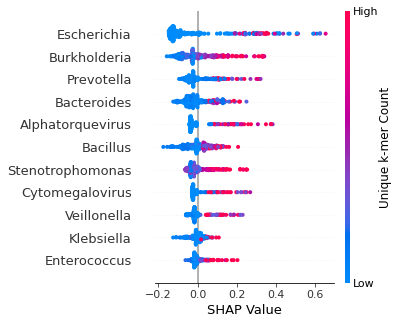

In [13]:
# Get SHAP summary before removing Cellulomonas and Agrobacterium
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=raw_CR, y=y)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_pre = pre_explainer.shap_values(raw_CR)

shap.summary_plot(shap_pre, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'pre_shap.png', dpi=600, format='png', bbox_inches='tight')


### Drop features

In [14]:
# Normalise Datasets
RA_CR = raw_CR.apply(func=lambda x: x / x.sum(), axis=1)

### Number of Features

In [15]:
print('Neat', X.shape)
print('CR', raw_CR.shape)

Neat (284, 1056)
CR (284, 11)


### Optimise decontaminated models

#### Pathogens

In [16]:
# raw_CR_model, raw_CR_results, raw_CR_params = optimise(raw_CR, y)
raw_CR_params = {'subsample': 0.7631578947368421, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 426, 'max_depth': 1, 'gamma': 0.0, 'colsample_bytree': 0.1}
raw_CR_model, raw_CR_results, _ = optimise(raw_CR, y, raw_CR_params)
# RA_CR_model, RA_CR_results, RA_CR_params = optimise(RA_CR, y)
RA_CR_params = {'subsample': 0.38421052631578945, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 101, 'max_depth': 5, 'gamma': 2.894736842105263, 'colsample_bytree': 0.19473684210526315}
RA_CR_model, RA_CR_results, _ = optimise(RA_CR, y, RA_CR_params)

In [17]:
metric_CR_df = pd.DataFrame({'Raw CR': raw_CR_results, 'RA CR': RA_CR_results}).round(3).T
metric_df = metric_df.append(metric_CR_df)
display(metric_df)

,test_precision,test_recall,test_AUROC
Raw,0.936,0.880,0.982
RA,0.942,0.940,0.982
Raw CR,0.833,0.794,0.928
RA CR,0.887,0.778,0.929


In [18]:
300620_STOPPPPP

SyntaxError: invalid token (<ipython-input-18-eb4b9819f96b>, line 1)

## Interpreting model using SHAP values

### Plot of SHAP values per Feature

In [19]:
import matplotlib.pyplot as plt
explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

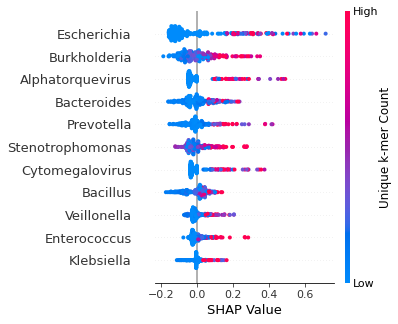

In [21]:
shap.summary_plot(shap_CR, raw_CR, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=35)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'CR_shap.png', dpi=600, format='png', bbox_inches='tight')

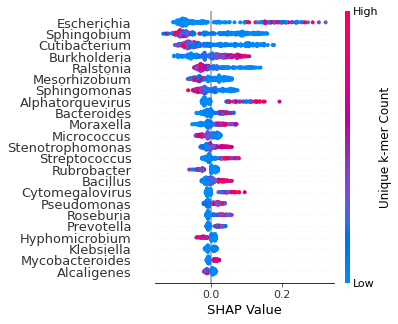

In [22]:
shap.summary_plot(shap_raw, X, show=False, plot_size=(4, 5), color_bar_label='Unique k-mer Count', max_display=23)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'raw_shap.png', dpi=600, format='png', bbox_inches='tight')

* Features are ranked by importance from top to botttom
* feature values are the kmer counts for each genus
* SHAP values are the average marginal contributions to probability

### Force plot for healthy patient

Actual Classification 1
201


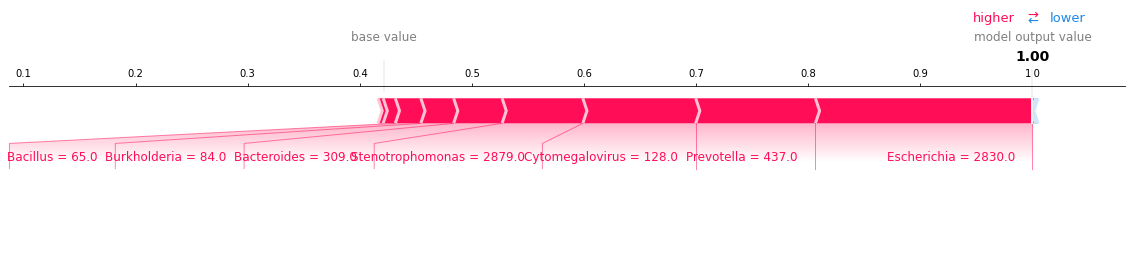

In [30]:
j = 201
print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])
shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True)
plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')

## How much does Escherichia drive predictions?

In [31]:
raw_CR.columns

Index(['Prevotella', 'Enterococcus', 'Bacillus', 'Escherichia', 'Klebsiella',
       'Cytomegalovirus', 'Veillonella', 'Stenotrophomonas',
       'Alphatorquevirus', 'Bacteroides', 'Burkholderia'],
      dtype='object')

In [33]:
no_ecoli_model, no_ecoli_results, no_ecoli_params = optimise(raw_CR.drop('Escherichia', axis=1), y)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 540 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done 2540 tasks      | elapsed:   16.0s
[Parallel(n_jobs=10)]: Done 4981 out of 5000 | elapsed:   28.9s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   29.0s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


{'subsample': 1.0, 'scale_pos_weight': 1.4273504273504274, 'n_estimators': 420, 'max_depth': 2, 'gamma': 2.631578947368421, 'colsample_bytree': 0.1}
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1048 tasks      | elapsed:    4.9s
[Parallel(n_jobs=10)]: Done 3048 tasks      | elapsed:   15.4s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   25.3s finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 330 tasks      | elapsed:    1.9s
[Parallel(n_jobs=10)]: Done 980 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 2380 tasks      | elapsed:   12.2s
[Parallel(n_jobs=10)]: Done 4180 tasks      | elapsed:   21.1s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   25.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1100 tasks      | elapsed:    6.3s
[Parallel(n_jobs=10)]: Done 3100 tasks      | elapsed:   16.9s
[Parallel(n_jobs=10)]: Done 4981 out of 5000 | elapsed:   26.2s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   26.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 1100 tasks      | elapsed:    5.3s
[Parallel(n_jobs=10)]: Done 3100 tasks      | elapsed:   14.9s
[Parallel(n_jobs=10)]: Done 4981 out of 5000 | elapsed:   23.9s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   24.1s finished


Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  40 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 1100 tasks      | elapsed:    5.9s
[Parallel(n_jobs=10)]: Done 3100 tasks      | elapsed:   16.1s
[Parallel(n_jobs=10)]: Done 4981 out of 5000 | elapsed:   25.2s remaining:    0.1s
[Parallel(n_jobs=10)]: Done 5000 out of 5000 | elapsed:   25.3s finished


In [34]:
no_ecoli_results

test_precision    0.747177
test_recall       0.727174
test_AUROC        0.858134
dtype: float64